## PhD Workshop Session 1: Enzyme Kinetics Data Processing with Python

In this session, we will be processing some data from an enzyme kinetics experiment, where we want to find the $V_{max}$ and $k_m$ of a glycoside hydrolase enzyme using a fluorogenic substrate. 

We will be using a spreadsheet with the fluorescence measurements (RFU) from a 96-well plate laid out as below:

|   | 4MUg | 4MUg | 4MUg |  4MU | 4MU  | 4MU  |   
|---|---|---|---|---|---|---|
| Well position  |  1 |  2 |  3 | 4  | 5  |  6 | 
| A  | 2000  |  2000 | 2000  | 10  |10   |10   |   
| B  | 1000  |  1000 |  1000 | 5  | 5  | 5  |   
| C  |  500 | 500  | 500  | 2.5  | 2.5  | 2.5  |   
| D  | 250  | 250  | 250  | 1.25  | 1.25  | 1.25  |   
| E  |  125 | 125  | 125  | 0.625  | 0.625  | 0.625  |   
| F  | 62.5  | 62.5  | 62.5  | 0.3125  |  0.3125 | 0.3125  |   
| G  |  31.25 | 31.25  | 31.25  | 0.15625  | 0.15625  | 0.15625  |   
| H  | 0  | 0  | 0  | 0  | 0  | 0  |

At the end of this notebook, we will have produced a plot of turnover [$min^{-1}$] vs concentration of 4MU [$\mu M$].

### Step 1: Importing the data

In [1]:
file_name = './session1_data.xlsx'

# We will be using a library called pandas to handle the data.
import pandas as pd

# The next few lines import the data and convert it into a convenient form for us
# Don't worry about the specifics, just know that pandas is useful for formatting data
df_input = pd.read_excel(
    io=file_name,
    sheet_name="Raw data ",
    skiprows=[0,1,2,3,4,5,6,7,8,10],
    header=0,
    usecols="B:AX",
)

df_input["Time"] = pd.to_timedelta(df_input["Unnamed: 1"])
df_input = df_input.set_index("Time")
df_input = df_input.set_index(df_input.index.seconds)
df_input = df_input.drop(columns=["Unnamed: 1"])
df_input.head() # this prints just the first 5 lines for us to see

,A01,A02,A03,A04,A05,A06,B01,B02,B03,B04,...,G03,G04,G05,G06,H01,H02,H03,H04,H05,H06
Time,,,,,,,,,,,,,,,,,,,,,
0,1621453,1713331,1652531,94912,96108,97644,1089967,1115748,1079516,69148,...,76004,11313,19106,11616,13706,13156,13439,9868,10035,9688
20,1734438,1750233,1700808,95559,95987,97306,1115190,1140444,1100990,69291,...,77722,11104,18766,11401,13512,13348,13069,9747,10092,9624
40,1760141,1769569,1706551,96205,96527,97387,1142168,1163928,1114137,69427,...,80191,11205,18771,11543,13362,12847,13163,9774,10025,9578
60,1768005,1791346,1721165,95988,96995,97429,1159589,1183727,1134031,69036,...,81962,11100,18672,11574,13433,12795,13090,9784,10180,9518
80,1782316,1813299,1745239,95130,96402,97572,1174171,1207084,1145885,69587,...,84689,11105,18535,11348,13420,12721,12950,9680,10107,9564


Now we have a `pandas DataFrame` containing the fluorescence measurement in each well for each time point.

### Step 2: Standard dilution 4MU

We need to get the the slope and intercept of the RFU vs concentration for the 4MU standard. 

Let's first extract this data from our DataFrame and the plate layout. We know the 4MU standard wells are in columns 4-6 on the plate. 

In [2]:
# Define the concentration of 4MU in each of the wells in columns 4-6
standard_conc_dict = {
    "A": 10,
    "B": 5,
    "C": 2.5,
    "D": 1.25,
    "E": 0.625,
    "F": 0.3125,
    "G": 0.15625,
    "H": 0,
}

# Define a list of wells and their concentrations we want to use in this section (A-H 4-6)
standard_wells = []
conc_list = []
for well in list(df_input.keys()):
    if int(well[2]) > 3: # selects only wells which are in columns 4-6
        standard_wells.append(well)

# Extract the data we want from the raw data
df_standards = df_input[standard_wells]
df_standards = df_standards.melt(ignore_index=False, var_name="Well", value_name="RFU")

# Add the concentration column
df_standards["Concentration"] = [standard_conc_dict[well[0]] for well in df_standards.Well]

df_standards


,Well,RFU,Concentration
Time,,,
0,A04,94912,10.0
20,A04,95559,10.0
40,A04,96205,10.0
60,A04,95988,10.0
80,A04,95130,10.0
...,...,...,...
1660,H06,8883,0.0
1680,H06,8884,0.0
1700,H06,8912,0.0


We now want to plot the average RFU at the last timepoint for each concentration, and find the slope and intercept of the line of best fit.

In [3]:
# Select the last timepoint t = 1740 s
last_timepoint = df_standards[df_standards.index == 1740]
last_timepoint

,Well,RFU,Concentration
Time,,,
1740,A04,103423,10.00000
1740,A05,104693,10.00000
1740,A06,105131,10.00000
1740,B04,66422,5.00000
1740,B05,66600,5.00000
1740,B06,66838,5.00000
1740,C04,35999,2.50000
1740,C05,35193,2.50000
1740,C06,35106,2.50000


There was something wrong with the experiment, we want to ignore the values where concentration = 10 $\mu M$. Let's do that now

In [4]:
last_timepoint = last_timepoint[last_timepoint.Concentration < 10]
last_timepoint

,Well,RFU,Concentration
Time,,,
1740,B04,66422,5.00000
1740,B05,66600,5.00000
1740,B06,66838,5.00000
1740,C04,35999,2.50000
1740,C05,35193,2.50000
1740,C06,35106,2.50000
1740,D04,22154,1.25000
1740,D05,22146,1.25000
1740,D06,22487,1.25000


Line of best fit is y = 11310.976106934004 * x + 8945.84461152882


Text(0.5, 1.0, 'y = 11310.976106934004 * x + 8945.84461152882')

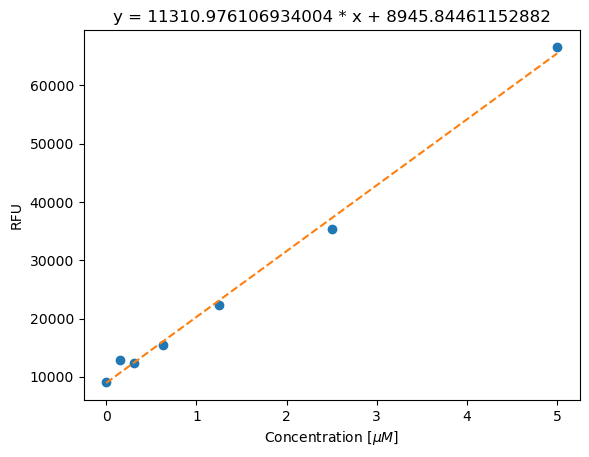

In [5]:
# Fit a line of best fit with least squares with numpy
import numpy as np

# Find the mean of replicates in each concentration
x = []
y = []
for concentration in set(last_timepoint.Concentration):
    x.append(concentration)
    y.append(last_timepoint[last_timepoint.Concentration == concentration].RFU.mean())

# Fit a 1d polynomial (line of best fit) by least squares
slope, intercept = np.polyfit(x, y, 1)
print(f"Line of best fit is y = {slope} * x + {intercept}")

# Plot the line of best fit to check
import matplotlib.pyplot as plt

plt.figure()
plt.plot(x, y, "o")  # Original data points
x_points = np.linspace(0, max(x))
y_points = slope * x_points + intercept
plt.plot(x_points, y_points, "--")  # Line of best fit
plt.xlabel("Concentration [$\mu M$]")
plt.ylabel("RFU")
plt.title(f"y = {slope} * x + {intercept}")

### Step 3: Calculating turnover rate for 4MUg substrate dilution

Now that we have the slope and intercept for 4MU, let's now calculate the concentration of 4MUg produced in the assay.

Like before, we need to extract the 4MUg wells from the raw data. 

In [6]:
# Define the concentration of 4MU in each of the wells in columns 4-6
conc_4MUg_dict = {
    "A": 2000,
    "B": 1000,
    "C": 500,
    "D": 250,
    "E": 125,
    "F": 62.5,
    "G": 31.25,
    "H": 0,
}

# Define a list of wells and their concentrations we want to use in this section (A-H 1-3)
wells_4MUg = []
conc_list = []
for well in list(df_input.keys()):
    if int(well[2]) < 4: # selects only wells which are in columns 4-6
        wells_4MUg.append(well)

# Extract the data we want from the raw data
df_4MUg = df_input[wells_4MUg]
df_4MUg = df_4MUg.melt(ignore_index=False, var_name="Well", value_name="RFU")

# Add the concentration column
df_4MUg["Concentration"] = [conc_4MUg_dict[well[0]] for well in df_4MUg.Well]
df_4MUg


,Well,RFU,Concentration
Time,,,
0,A01,1621453,2000.0
20,A01,1734438,2000.0
40,A01,1760141,2000.0
60,A01,1768005,2000.0
80,A01,1782316,2000.0
...,...,...,...
1660,H03,11263,0.0
1680,H03,11279,0.0
1700,H03,11069,0.0


Again, we'll need to extract the final timepoint RFU for each well.

In [7]:
last_timepoint_4MUg = df_4MUg[df_4MUg.index == 1740]
last_timepoint_4MUg

,Well,RFU,Concentration
Time,,,
1740,A01,4295250,2000.00
1740,A02,4489694,2000.00
1740,A03,4176610,2000.00
1740,B01,3504423,1000.00
1740,B02,3654954,1000.00
1740,B03,3324655,1000.00
1740,C01,2459797,500.00
1740,C02,2576244,500.00
1740,C03,2321844,500.00


We need to use the standards slope and intercept to determine the concentration of 4MU produced over the 1740 seconds.

For this, we will do the calculation:

$$[4MU]_{t=1740 s} = \frac{RFU_{t=1740 s} - intercept}{slope}$$

In [8]:
# Over the entire experiment
last_timepoint_4MUg = last_timepoint_4MUg.assign(Conc_4MU_1740s = (last_timepoint_4MUg["RFU"] - intercept) / slope)

# Concentration of 4MU produced per minute
last_timepoint_4MUg = last_timepoint_4MUg.assign(Conc_4MU_1min = (last_timepoint_4MUg["Conc_4MU_1740s"] / 1740) * 60)

last_timepoint_4MUg

,Well,RFU,Concentration,Conc_4MU_1740s,Conc_4MU_1min
Time,,,,,
1740,A01,4295250,2000.00,378.950863,13.067271
1740,A02,4489694,2000.00,396.141598,13.660055
1740,A03,4176610,2000.00,368.461936,12.705584
1740,B01,3504423,1000.00,309.034085,10.656348
1740,B02,3654954,1000.00,322.342486,11.115258
1740,B03,3324655,1000.00,293.140850,10.108305
1740,C01,2459797,500.00,216.679014,7.471690
1740,C02,2576244,500.00,226.974059,7.826692
1740,C03,2321844,500.00,204.482631,7.051125


Let's plot the results

Text(0, 0.5, 'Turnover rate [$min^{-1}$]')

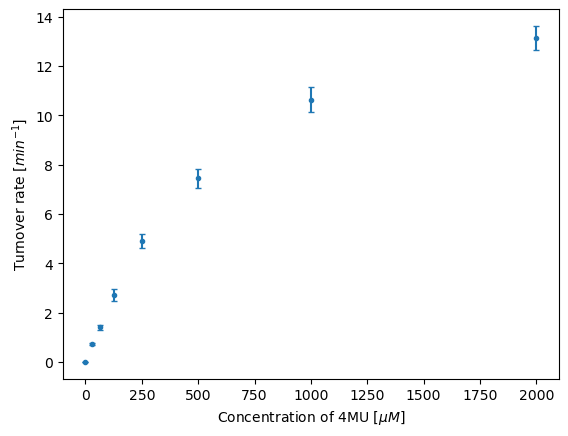

In [9]:
means = last_timepoint_4MUg.groupby(["Concentration"]).Conc_4MU_1min.mean()
std = last_timepoint_4MUg.groupby(["Concentration"]).Conc_4MU_1min.std()

plt.errorbar(
    x=means.keys(),
    y=means.values,
    yerr=std.values,
    linestyle="",
    marker=".",
    capsize=2
)

plt.xlabel("Concentration of 4MU [$\mu M$]")
plt.ylabel("Turnover rate [$min^{-1}$]")

### Step 4: Finding $V_{max}$ and $k_m$

We need to fit a curve through the turnover vs. concentration data. We will use the mean turnover value for the three replicates in each concentration.

Text(0, 0.5, 'Turnover rate [$min^{-1}$]')

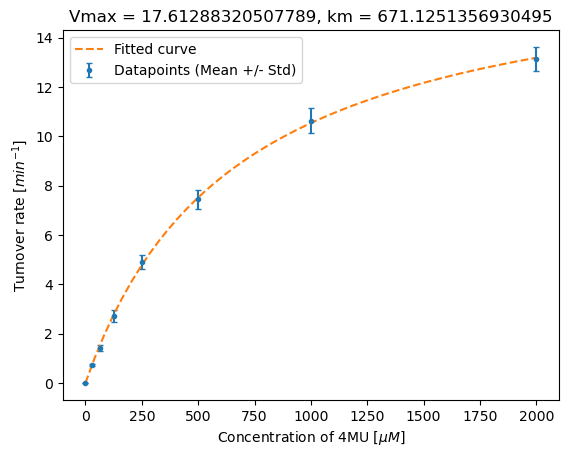

In [10]:
# Use scipy optimise to fit the curve
from scipy.optimize import curve_fit

# Define a function f to fit to the data
def f(x, vmax, km):
    return vmax * x / (km + x)

# Define x and y data to fit
x = means.keys()  # concentrations
y = means.values  # turnover rate [min-1]

# Fit the curve
popt, pcov = curve_fit(f, x, y)

# Plot results
# Error bar plot from previous cell
plt.errorbar(
    x=means.keys(),
    y=means.values,
    yerr=std.values,
    linestyle="",
    marker=".",
    capsize=2,
    label="Datapoints (Mean +/- Std)"
)

# Fitted curve
plt.plot(np.linspace(0,max(means.keys())), f(np.linspace(0,max(means.keys())), *popt), "--", label="Fitted curve")
plt.legend()

plt.title(f"Vmax = {popt[0]}, km = {popt[1]}")

plt.xlabel("Concentration of 4MU [$\mu M$]")
plt.ylabel("Turnover rate [$min^{-1}$]")